In [1]:
# 首先加载必用的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
# 我们使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.text import Tokenizer





In [2]:
pd_all = pd.read_csv('C:/Users/86180/Desktop/ChnSentiCorp_htl_all.csv')

In [3]:
pd_all.shape
#前5322条为正向，后为负向

(7765, 2)

In [4]:
pd_all.head()

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [5]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('E:/BaiduNetdiskDownload/sgns.zhihu.bigram', binary=False)
# 每一个词都对应一个长度为300的向量


In [6]:
len(cn_model.index2word)

259883

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\86180\AppData\Local\Temp\jieba.cache
Loading model cost 0.719 seconds.
Prefix dict has been built successfully.


平均tokens的长度67.75582743077914
最长的评价的tokens的长度1540


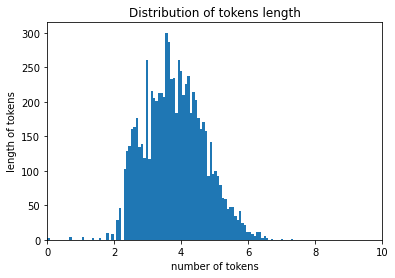

In [7]:
#存储所有评价，每例评价为一条string
train_texts_orig = list(pd_all.review)
#前
train_tokens = []

#分词和tokenize
#首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，
#所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\'%]+|[+——！，。？、~@#￥%……&*（）]+", "", text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)


# 最长的评价tokens的长度
np.max(num_tokens)
print('平均tokens的长度{}'.format(np.mean(num_tokens)))
print('最长的评价的tokens的长度{}'.format(np.max(num_tokens)))
plt.hist(np.log(num_tokens), bins=100)
plt.xlim((0, 10))
plt.ylabel('length of tokens')
plt.xlabel('number of tokens')
plt.title('Distribution of tokens length')
plt.show()


In [9]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

222

In [10]:
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9563425627817128

In [85]:
# # 初始化embedding_matrix，之后在keras上进行应用
# num_words = 259883
# embedding_dim = 300
# embedding_matrix = np.zeros((num_words, embedding_dim))
# # embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# # 维度为 259883 * 300
# for i in range(num_words):
 
#     embedding_matrix[i, :] = cn_model[cn_model.index2word[i]]
#     print("progress:{0}%".format(round((i + 1) * 100 / num_words)), end="\r")
#     embedding_matrix = embedding_matrix.astype('float32')


In [ ]:
# embedding_matrix_df = pd.DataFrame(embedding_matrix)

In [ ]:
# embedding_matrix_df.to_csv('embedding_matrix_df.csv')

In [12]:
embedding_matrix_df=pd.read_csv('embedding_matrix_df.csv')

In [84]:
embedding_matrix_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,-0.801784,-0.165340,0.030508,-0.117380,0.344886,-0.619519,-0.163887,-0.256985,-0.136003,...,0.055162,0.126540,0.464693,0.476686,0.387382,-0.822759,-0.504953,0.106525,0.553436,0.436650
1,1,-0.651747,0.535970,0.340271,0.070466,0.335049,-0.681975,-0.573658,0.318913,-0.042395,...,-0.015890,0.604637,-0.400023,0.038662,0.473588,-0.735384,-1.047046,0.805399,0.104593,0.193694
2,2,-0.412321,0.228261,0.207114,-0.245406,-0.292829,-0.082571,-0.882113,-0.141292,0.057696,...,-0.026220,0.303933,0.357741,-0.184716,-0.497120,-0.390048,-0.258891,0.808777,0.056751,0.452374
3,3,-0.505105,-0.412067,-0.041826,-0.055158,-0.826903,-0.868761,-0.689815,-0.074329,-0.741576,...,0.125112,-0.677940,0.548021,-0.542195,-0.270064,0.252053,0.215630,1.569453,-0.358775,-0.300759
4,4,0.577619,-0.821557,-0.440517,0.049569,0.754438,-0.617761,0.273806,-0.302287,0.510386,...,-0.267514,0.553856,0.764344,0.775949,0.836743,0.247767,-0.702770,-0.229911,-0.003598,0.074756


In [13]:
train_pad = pad_sequences(train_tokens, maxlen=max_tokens, padding='pre', truncating='pre')

In [14]:
train_pad[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [15]:
train_target = np.concatenate( (np.ones(5322), np.zeros(7765-5322)) )
# 进行训练和测试样本的分割
 
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=12)



### 普通LSTM

In [70]:
#用LSTM对样本进行分类训练
model1=Sequential()
model1.add(Embedding(num_words,embedding_dim,
                    weights=[embedding_matrix],
                   input_length=max_tokens,
                   trainable=False))
model1.add(LSTM(units=64))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

#优化器，损失函数二元交叉熵，评估标准acc
model1.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])


In [71]:
model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 222, 300)          77964900  
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
module_wrapper_43 (ModuleWra (None, 64)                0         
_________________________________________________________________
module_wrapper_44 (ModuleWra (None, 1)                 65        
Total params: 78,058,405
Trainable params: 93,505
Non-trainable params: 77,964,900
_________________________________________________________________


In [72]:
# 开始训练
model1.fit(X_train, y_train, validation_split=0.1,epochs=50,batch_size=128)
result1 = model1.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result1[1]))

Epoch 1/50
50/50 [==============================] - 27s 478ms/step - loss: 0.5345 - acc: 0.7284 - val_loss: 0.4325 - val_acc: 0.8112
Epoch 2/50
50/50 [==============================] - 24s 473ms/step - loss: 0.4377 - acc: 0.7949 - val_loss: 0.4059 - val_acc: 0.8312
Epoch 3/50
50/50 [==============================] - 24s 475ms/step - loss: 0.3971 - acc: 0.8286 - val_loss: 0.4135 - val_acc: 0.7969
Epoch 4/50
50/50 [==============================] - 24s 477ms/step - loss: 0.3660 - acc: 0.8431 - val_loss: 0.4617 - val_acc: 0.7825
Epoch 5/50
50/50 [==============================] - 24s 476ms/step - loss: 0.3422 - acc: 0.8572 - val_loss: 0.4296 - val_acc: 0.8197
Epoch 6/50
50/50 [==============================] - 24s 477ms/step - loss: 0.3599 - acc: 0.8375 - val_loss: 0.8222 - val_acc: 0.6853
Epoch 7/50
50/50 [==============================] - 24s 480ms/step - loss: 0.3241 - acc: 0.8650 - val_loss: 0.5935 - val_acc: 0.7167
Epoch 8/50
50/50 [==============================] - 24s 480ms/step - 

### 基于栈式 LSTM 的序列分类
### 在这个模型中，我们将 3 个 LSTM 层叠在一起，使模型能够学习更高层次的时间表示。

In [74]:
model11=Sequential()
model11.add(Embedding(num_words,embedding_dim,
                    weights=[embedding_matrix],
                   input_length=max_tokens,
                   trainable=False))
model11.add(LSTM(32, return_sequences=True))  # 返回维度为 32 的向量序列
model11.add(LSTM(32, return_sequences=True))  # 返回维度为 32 的向量序列
model11.add(LSTM(32))  # 返回维度为 32 的单个向量
model11.add(Dense(1, activation='sigmoid'))

model11.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [75]:
model11.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 222, 300)          77964900  
_________________________________________________________________
lstm_7 (LSTM)                (None, 222, 32)           42624     
_________________________________________________________________
lstm_8 (LSTM)                (None, 222, 32)           8320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
module_wrapper_45 (ModuleWra (None, 1)                 33        
Total params: 78,024,197
Trainable params: 59,297
Non-trainable params: 77,964,900
_________________________________________________________________


In [77]:
# 开始训练
model11.fit(X_train, y_train, validation_split=0.1,epochs=10,batch_size=128)
result11 = model11.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result11[1]))

Epoch 1/10
50/50 [==============================] - 36s 717ms/step - loss: 0.4911 - acc: 0.7594 - val_loss: 0.4739 - val_acc: 0.7439
Epoch 2/10
50/50 [==============================] - 35s 697ms/step - loss: 0.4312 - acc: 0.7979 - val_loss: 0.4073 - val_acc: 0.8255
Epoch 3/10
50/50 [==============================] - 35s 700ms/step - loss: 0.3934 - acc: 0.8241 - val_loss: 0.4139 - val_acc: 0.8283
Epoch 4/10
50/50 [==============================] - 34s 683ms/step - loss: 0.3666 - acc: 0.8412 - val_loss: 0.3866 - val_acc: 0.8212
Epoch 5/10
50/50 [==============================] - 34s 686ms/step - loss: 0.3419 - acc: 0.8507 - val_loss: 0.3482 - val_acc: 0.8455
Epoch 6/10
50/50 [==============================] - 34s 681ms/step - loss: 0.3241 - acc: 0.8585 - val_loss: 0.3861 - val_acc: 0.8469
Epoch 7/10
50/50 [==============================] - 33s 660ms/step - loss: 0.3057 - acc: 0.8704 - val_loss: 0.3956 - val_acc: 0.8340
Epoch 8/10
50/50 [==============================] - 34s 689ms/step - 

In [25]:
from keras.layers import Dense, Dropout

In [81]:
#多层感知机训练

model2 = Sequential()
model2.add(Embedding(num_words,embedding_dim,
                    weights=[embedding_matrix],
                   input_length=max_tokens, 
                   trainable=False))
model2.add(Dense(64, input_dim=20, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])



In [82]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 222, 300)          77964900  
_________________________________________________________________
module_wrapper_50 (ModuleWra (None, 222, 64)           19264     
_________________________________________________________________
module_wrapper_51 (ModuleWra (None, 222, 64)           0         
_________________________________________________________________
module_wrapper_52 (ModuleWra (None, 222, 64)           4160      
_________________________________________________________________
module_wrapper_53 (ModuleWra (None, 222, 64)           0         
_________________________________________________________________
module_wrapper_54 (ModuleWra (None, 222, 1)            65        
Total params: 77,988,389
Trainable params: 23,489
Non-trainable params: 77,964,900
____________________________________

In [83]:
model2.fit(X_train, y_train, validation_split=0.1,epochs=50,batch_size=128)
result2 = model2.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result2[1]))

Epoch 1/50
50/50 [==============================] - 6s 107ms/step - loss: 0.6434 - acc: 0.6677 - val_loss: 0.5917 - val_acc: 0.7210
Epoch 2/50
50/50 [==============================] - 5s 103ms/step - loss: 0.6285 - acc: 0.6824 - val_loss: 0.6276 - val_acc: 0.7188
Epoch 3/50
50/50 [==============================] - 5s 103ms/step - loss: 0.6249 - acc: 0.6839 - val_loss: 0.5888 - val_acc: 0.7214
Epoch 4/50
50/50 [==============================] - 5s 104ms/step - loss: 0.6226 - acc: 0.6852 - val_loss: 0.6142 - val_acc: 0.7191
Epoch 5/50
50/50 [==============================] - 5s 104ms/step - loss: 0.6205 - acc: 0.6859 - val_loss: 0.5853 - val_acc: 0.7203
Epoch 6/50
50/50 [==============================] - 5s 104ms/step - loss: 0.6214 - acc: 0.6860 - val_loss: 0.5981 - val_acc: 0.7219
Epoch 7/50
50/50 [==============================] - 5s 104ms/step - loss: 0.6189 - acc: 0.6868 - val_loss: 0.6063 - val_acc: 0.7219
Epoch 8/50
50/50 [==============================] - 5s 104ms/step - loss: 0.

In [63]:
from keras.layers.recurrent import SimpleRNN

In [64]:
# 用simple-rnn对样本进行分类训练
model3 = Sequential()
# 模型第一层为embedding
model3.add(Embedding(num_words,embedding_dim,
                    weights=[embedding_matrix],
                   input_length=max_tokens,
                   trainable=False))
model3.add(SimpleRNN(units=32))
model.add(Dropout(0.5))

# 最后是一个全链接层，用sigmoid激活函数输出结果。
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])


In [65]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 222, 300)          77964900  
_________________________________________________________________
module_wrapper_39 (ModuleWra (None, 32)                10656     
_________________________________________________________________
module_wrapper_40 (ModuleWra (None, 1)                 33        
Total params: 77,975,589
Trainable params: 10,689
Non-trainable params: 77,964,900
_________________________________________________________________


In [66]:
model3.fit(X_train, y_train, validation_split=0.1,epochs=50,batch_size=128)
result3 = model3.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result3[1]))

Epoch 1/50
50/50 [==============================] - 5s 65ms/step - loss: 0.6130 - acc: 0.6653 - val_loss: 0.5524 - val_acc: 0.7110
Epoch 2/50
50/50 [==============================] - 3s 62ms/step - loss: 0.5404 - acc: 0.7311 - val_loss: 0.5159 - val_acc: 0.7368
Epoch 3/50
50/50 [==============================] - 3s 63ms/step - loss: 0.4831 - acc: 0.7699 - val_loss: 0.4704 - val_acc: 0.7854
Epoch 4/50
50/50 [==============================] - 3s 62ms/step - loss: 0.4529 - acc: 0.7885 - val_loss: 0.4506 - val_acc: 0.8026
Epoch 5/50
50/50 [==============================] - 3s 62ms/step - loss: 0.4398 - acc: 0.8017 - val_loss: 0.4677 - val_acc: 0.7825
Epoch 6/50
50/50 [==============================] - 3s 62ms/step - loss: 0.4444 - acc: 0.8014 - val_loss: 0.4538 - val_acc: 0.8026
Epoch 7/50
50/50 [==============================] - 3s 62ms/step - loss: 0.4090 - acc: 0.8198 - val_loss: 0.4895 - val_acc: 0.7697
Epoch 8/50
50/50 [==============================] - 3s 62ms/step - loss: 0.4002 - a